In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!apt install swig
!pip3 install box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 32 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,314 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpacking swig3.0 (3.0.12-1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_3.0.12-1_amd64.deb ...
Unpackin

In [0]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import random
from collections import namedtuple
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings('ignore')

In [0]:
env = gym.make('LunarLander-v2')

In [5]:
num_state = env.observation_space.shape[0]
num_action = env.action_space.n
print(num_state)
print(num_action)

8
4


In [0]:
# create a neural network
class network(nn.Module):
    
    def __init__(self , num_state , num_action):
        
        super().__init__()
        self.fc1 = nn.Linear(num_state , 50 )
        ## more hidden
        self.out = nn.Linear(50 , num_action )
        
    def forward(self , x):
        
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

class ReplayBuffer(object):
    '''
    This code is copied from openAI baselines
    https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py
    '''
    def __init__(self, size):
        self._storage = []
        self._maxsize = size 
        self._next_idx = 0 # index
    # return storage length
    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        #　current state ,action ,reward ,next_state .done
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize # indicate empty

    def _encode_sample(self, idxes , dtype = np.float32):
        # sample some data in idxes
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False,dtype=dtype))
            actions.append(np.array(action, copy=False,dtype=np.long))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False,dtype=dtype))
            dones.append(done)
        return np.array(obses_t,dtype=dtype), np.array(actions , dtype = np.long), \
    np.array(rewards  ,dtype=dtype), np.array(obses_tp1,dtype=dtype), np.array(dones , dtype = bool)
    
    
    def sample(self, batch_size):
        # sample some data in replay buffer
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

    
class Agent():
    
    def __init__(self , num_state , num_action):
        
        
        # q-learning is off-policy
        self.policy_network = network(num_state , num_action)
        self.target_network = network(num_state , num_action)
        
        # target_network use parameter in policy_network
        self.target_network.load_state_dict(self.policy_network.state_dict())
        
        self.steps_done = 0
        self.num_state = num_state
        self.num_action = num_action
        
        # what is the purpose of EPS?? use eps-greedy
        self.EPS_END = 0.05
        self.EPS_START = 0.999
        
        self.EPS_DECAY = 1000
        self.batch_size = 64
        self.buffer = ReplayBuffer( 4000 ) # create a replay buffer with size 4000
        # amsgrad: whether to use the AMSGrad variant of this algorithm from the paper On the Convergence of Adam and Beyond
        self.optimizer = torch.optim.Adam(self.policy_network.parameters()   , amsgrad=True) # define optimizer
        
    def take_action(self , x , is_testing = False ) : # testing mean that we don't sue eps-greddy
        # use eps-greedy
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
            math.exp(-1. * self.steps_done / self.EPS_DECAY)
        
        x = x.astype(np.float32)
        x = torch.from_numpy(x) # numpy transform into torch
        rand_val = np.random.uniform() # Samples are uniformly distributed over the half-open interval [low, high)
        if rand_val > eps_threshold or is_testing == True:
            val = self.policy_network(x)
            # argmax: Returns the indices of the maximum value of all elements in the input tensor.
            # item: transfor into int
            action = torch.argmax(val).item() 
        else:
            action = np.random.randint(0 , self.num_action )
        
        if is_testing == False:
            self.steps_done += 1
        
        return action
            
    # store state information in replay buffer
    def store_transition(self, state , action , reward , next_state , done ):
        
        self.buffer.add(state , action , reward , next_state , done)
    
    def update_parameters(self):
        # need read again
        # buffer length is not enough to sample
        if len(self.buffer) < self.batch_size:
            return 
        # use MSELoss
        loss_fn = torch.nn.MSELoss(reduction = 'mean')
        
        batch = self.buffer.sample(self.batch_size)
        states , actions , rewards , next_states , dones = batch
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions).view(-1,1) # equal numpy.reshape
        rewards = torch.from_numpy(rewards)
        next_states = torch.from_numpy(next_states)
        actions = actions.long() # Q: ??
        
        # Q: identify state is final state or not/
        # the input of lambda is done
        non_final_mask = torch.tensor(tuple(map(lambda s : s != True, dones)) ,dtype = torch.bool)
        non_final_next_state = next_states[non_final_mask]
        
        # Q估計
        pred_q = self.policy_network(states).gather(1 , actions).view(-1)  # G(t)
        
        # detach的方法，将variable参数从网络中隔离开，不参与参数更新。
        next_state_value = torch.zeros(self.batch_size).detach()
        # use "target" to predict
        # Q: why need [0]?? return is (value ,index)
        next_state_value[non_final_mask] = self.target_network(non_final_next_state).max(1)[0] #  rt + argmax a'(st+1 ,a')
        expected_q = (next_state_value + rewards).detach() # Q現實
        
        
        loss = loss_fn(pred_q , expected_q) # TD error
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_weight(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())


In [0]:
from PIL import Image
import time
def get_snap_shot(agent ,env_name , gif_filename = None):
    try:
        
        if gif_filename != None:
            frames = []
        
        env = gym.make(env_name)
        state = env.reset()
        done = False
        rew_sum = 0.0
        while done == False:
            if gif_filename != None:
                frames.append(Image.fromarray(env.render(mode='rgb_array')))
            else:
                env.render()
            action = agent.take_action(state , is_testing = True)
            next_state , reward , done , _ = env.step(action)
            rew_sum += reward
            state = next_state[:]
        print('total reward',rew_sum)
        
        if gif_filename != None:
            with open(gif_filename,'wb') as f:
                im = Image.new('RGB', frames[0].size)
                im.save(f, save_all=True, append_images=frames)
        time.sleep(1.5) #Prevent kernel dead
        
    finally:
        env.close()
        
        

In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [9]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (47.1.1)


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
import os

In [11]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [12]:
agent = Agent(num_state , num_action)
reward_history = []
try:                
    env = gym.make('LunarLander-v2')
    for e in tqdm(range(2001)):
        state = env.reset()
        done = False
        reward_sum = 0.0
        while done == False:
            env.render()
            action = agent.take_action(state)
            next_state , reward , done , _ = env.step(action)
            # print(state)
            # reward shapping
            # 如果X軸偏離原本的位置，則給出懲罰
            # 如果機器有往下,給出獎勵 
            # 高度越高給出懲罰
            # 有旋轉也給出懲罰
            reward = reward - abs(state[0]) - abs(state[1]) - abs(state[4]) - state[3] * 10

            # reward = reward - abs(state[0]) + abs(state[1]+0.4) -abs(state[2]) - abs(state[3]) - abs(state[4]) - abs(state[5])
            reward_sum += reward
            agent.store_transition( state , action , reward , next_state , done )
            state = next_state[:]
            agent.update_parameters()
        # print('='*20)
        reward_history.append(reward_sum)
        val_dir = "/content/drive/My Drive/RL/LunarLander_gif/"
        if os.path.isdir(val_dir) == False:
            os.mkdir(val_dir)

        if e  % 50 == 0:
            print("e is" ,e)
            get_snap_shot(agent = agent ,env_name='LunarLander-v2' ,gif_filename= val_dir + '/episode_{}.gif'.format(e))
            # get_snap_shot(agent = agent)
        if e > 0 and e % 20 == 0:
            agent.update_target_weight()
finally:
    env.close()

e is 0
total reward -539.6580444189044
e is 50
total reward -268.55644538403374
e is 100
total reward -524.7384339465057
e is 150
total reward -358.737983750136
e is 200
total reward -195.49505668834394
e is 250
total reward -100.02496380077584
e is 300
total reward -219.71217477172334
e is 350
total reward -134.43985891539631
e is 400
total reward -284.0811755691624
e is 450
total reward -101.63905239485676
e is 500
total reward -238.7529759055729
e is 550
total reward -16.8229416645635
e is 600
total reward 5.629458659428863
e is 650
total reward -269.469211912834
e is 700
total reward -91.26863369405174
e is 750
total reward -39.78163366186887
e is 800
total reward -2.3535231159827674
e is 850
total reward -46.135439163605525
e is 900
total reward 171.57234698229786
e is 950
total reward 244.72310383115243
e is 1000
total reward -9.340882296824574
e is 1050
total reward 249.89313590606451
e is 1100
total reward 25.332680635176416
e is 1150
total reward 189.2835183336989
e is 1200
to

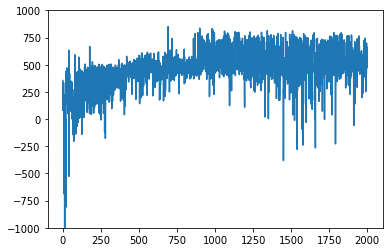

In [19]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.ylim(-1000 ,1000)
plt.savefig( val_dir + 'trend.png')#儲存圖片